# DES	simulation	assignment

Rinske ....  
Michael .....  
Ruben Lanjouw, 12415049

### 0 Imports

In [122]:
import simpy
import numpy as np
import random
import matplotlib.pyplot as plt
import math
import statistics

### 1 Proof DES_queue

In [245]:
def DES_queue(size, arrival_rate, service_rate, n, rate_prob=True, arrival_prob=True):
    """
    size = number of customers
    arrival_rate = rate of arrival of customers, lambda
    service_rate = rate of service of customers, mu
    n = number of servers
    """

    env = simpy.Environment()
    servers = simpy.Resource(env, capacity = n)

    inter_arrival_times = []
    service_times = []
    waiting_times = []


    def customer_processing(env, servers, arrival_rate, service_rate):
        ''' Process the customer'''
        arrival_time = env.now # time now

        with servers.request() as request:
            yield request  # wait untill the server is available
            wait_time = env.now - arrival_time
            waiting_times.append(wait_time)  # save the wait time
            ds = random.expovariate(service_rate)
            service_times.append(ds)
            yield env.timeout(ds)

    def customer_generator(env, size , servers, arrival_rate, service_rate):
        ''' Generates a costumer after a delay of the arrival time and processes the customer  '''
        # make numpy expovariate list
        for i in range(size):
            dt = random.expovariate(arrival_rate)
            inter_arrival_times.append(dt)
            yield env.timeout(dt) # wait for the next customer
            costomer = customer_processing(env,servers,arrival_rate,service_rate)
            env.process(costomer)

    env.process(customer_generator(env, size, servers,arrival_rate,service_rate))

    env.run()
    
    mean_interarrival = statistics.mean(inter_arrival_times)
    mean_waiting = statistics.mean(waiting_times)
    mean_service = statistics.mean(service_times)

    return [mean_interarrival, mean_waiting, mean_service, waiting_times]


### 2 Proof significance 

In [123]:

def calculate_expected_waiting_time(n, p, u):
    # Bereken rho
    if p >= 1:
        return "P DOES NOT WORK! DO NORMAL PLS :)"
    
    hfirst_term = ((n * p ) ** n) / math.factorial(n)
    
    hsecond_term = (1 - p) * sum(((n * p) ** i) / math.factorial(i) for i in range(n))
    hsecond_term += ((n * p) ** n) / math.factorial(n)
    hsecond_term = 1 / hsecond_term
    h = hfirst_term * hsecond_term
    second_term1 = 1 / (1 - p)
    second_term2 = 1 / (n * u)
    expected_waiting_time = h * second_term1 * second_term2

    return expected_waiting_time


def calculate_DES(number_of_rounds, arrival_rate, service_rate, number_of_servers, number_of_customers):
    results_waiting = []
    for _ in range(number_of_rounds):
        result = DES_queue(number_of_customers, arrival_rate, service_rate, number_of_servers, rate_prob=True, arrival_prob=True)
        results_waiting.append(result[1])
    # get avr over [_,x,_] 
    return np.mean(results_waiting), np.std(results_waiting), results_waiting


### 3 Shortest Job First

In [356]:
def DES_queue_SJF(size, arrival_rate, service_rate, n):
    """
    size = number of customers
    arrival_rate = rate of arrival of customers, lambda
    service_rate = rate of service of customers, mu
    n = number of servers
    """
    env = simpy.Environment()
    servers = simpy.Resource(env, capacity = n)

    inter_arrival_times = []
    service_times = []
    waiting_times = []


    def customer_processing(env, queue, size):
        ''' Process the customers with while loop checking for shortest job first'''
        processed = 0
        while processed < size:
            if len(queue) == 0:
                yield env.timeout(1)
                continue
            print(queue)
            shortest_job = min(queue, key=lambda x: x["service"])
            ds = shortest_job["service"]
            queue.remove(shortest_job)
            with servers.request() as request:
                yield request
                wait_time = env.now - shortest_job["arrival"]
                waiting_times.append(wait_time)
                service_times.append(ds)
                yield env.timeout(ds)
            processed += 1


    def customer_generator(env, size, arrival_rate, service_rate, queue):
        ''' Generates a costumer after a delay of the arrival time and processes the customer  '''
        # make 

        for i in range(size):
            dt = random.expovariate(arrival_rate)
            inter_arrival_times.append(dt)
            yield env.timeout(dt) # wait for the next customer
            ds = random.expovariate(service_rate)
            queue.append({"arrival" : env.now, "service" : ds})

    queue = []
    env.process(customer_generator(env, size,arrival_rate,service_rate, queue))
    env.process(customer_processing(env, queue,size))
    env.run()
    
    mean_interarrival = statistics.mean(inter_arrival_times)
    mean_waiting = statistics.mean(waiting_times)
    mean_service = statistics.mean(service_times)
    return [mean_interarrival, mean_waiting, mean_service, waiting_times]


DES_queue_SJF(100, 1, 1, 1)

[{'arrival': 0.016424444503438263, 'service': 3.2392389449385295}, {'arrival': 0.32070212479176907, 'service': 0.8270594214420467}]


TypeError: 'numpy.ndarray' object is not callable

In [ ]:
def DES_deter(size, arrival_rate, service_rate, n, method="deterministic"):
    """
    size = number of customers
    arrival_rate = rate of arrival of customers, lambda
    service_rate = rate of service of customers, mu
    n = number of servers
    """

    env = simpy.Environment()
    servers = simpy.Resource(env, capacity = n)

    inter_arrival_times = []
    service_times = []
    waiting_times = []


    def customer_processing(env, servers, service_rate, method="deterministic"):
        ''' Process the customer'''
        arrival_time = env.now # time now

        with servers.request() as request:
            yield request  # wait untill the server is available
            wait_time = env.now - arrival_time
            waiting_times.append(wait_time)  # save the wait time
            if method=="deterministic":
                ds = service_rate
            if method=="longtail":
                ds = 1 if random.random() < 0.75 else 5
            else:
                ds = random.expovariate(service_rate)
            service_times.append(ds)
            yield env.timeout(ds)

    def customer_generator(env, size , servers, arrival_rate, service_rate, method):
        ''' Generates a costumer after a delay of the arrival time and processes the customer  '''
        # make numpy expovariate list
        for i in range(size):
            dt = random.expovariate(arrival_rate)
            inter_arrival_times.append(dt)
            yield env.timeout(dt) # wait for the next customer
            costomer = customer_processing(env,servers,service_rate, method)
            env.process(costomer)

    env.process(customer_generator(env, size, servers,arrival_rate,service_rate, method))

    env.run()
    
    mean_interarrival = statistics.mean(inter_arrival_times)
    mean_waiting = statistics.mean(waiting_times)
    mean_service = statistics.mean(service_times)

    return [mean_interarrival, mean_waiting, mean_service, waiting_times]


### Plots

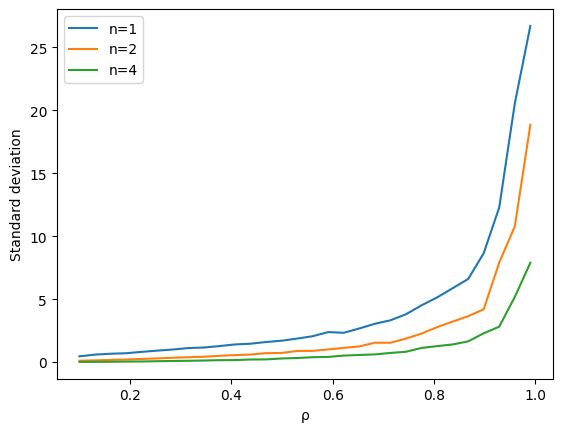

In [323]:
nl = [1,2,4]
u = 1
p = np.linspace(0.1, 0.99, 30)
for n in nl:
    mean = []
    lambd = u * p * n
    for p_i in p:
        lambd = u * p_i * n
        results = []
        # results2 = []
        for _ in range(5):
            result = DES_queue(10000, lambd, u, n)
            results.append(np.std(result[3]))
            # results2.append(result[1])
        # avr.append(np.mean(results2))
        mean.append(np.mean(results))
    plt.plot(p, mean, label=f"n={n}")

plt.legend()
plt.xlabel("\u03C1")
plt.ylabel("Standard deviation")
plt.show()

# make the avr relative to mean

In [329]:
# plot the mean waiting time for different number of servers with a confidence interval
servers = [1,2,4]
number_of_customers = 10000
rho = 0.7
mu = 10
number_of_rounds = 1000
means = []
stds = []

for n in servers:
    results = []
    lambd = (n * mu * rho)
    for i in range(number_of_rounds):
        result = DES_queue(number_of_customers, lambd, mu, n)
        results.append(result[1])
        if i % 100 == 0:
            print("Finished round ", i)
    mean = np.mean(results)
    std = np.std(results)
    means.append(mean)
    stds.append(std)
    print("Finished for n = ", n)

print(means)


Finished round  0
Finished round  100
Finished round  200
Finished round  300
Finished round  400
Finished round  500
Finished round  600
Finished round  700
Finished round  800
Finished round  900
Finished for n =  1
Finished round  0
Finished round  100
Finished round  200
Finished round  300
Finished round  400
Finished round  500
Finished round  600
Finished round  700
Finished round  800
Finished round  900
Finished for n =  2
Finished round  0
Finished round  100
Finished round  200
Finished round  300
Finished round  400
Finished round  500
Finished round  600
Finished round  700
Finished round  800
Finished round  900
Finished for n =  4
[0.23301240036041115, 0.09635991255477168, 0.03587415328346796]


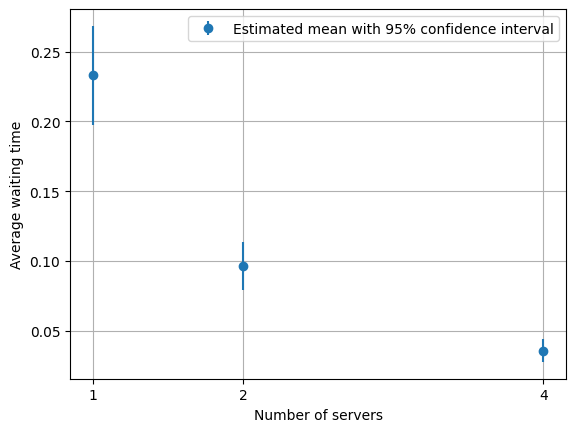

1 & 0.23301 & 0.198 & 0.268 & 0.23333 \\
2 & 0.09636 & 0.079 & 0.114 & 0.09608 \\
4 & 0.03587 & 0.028 & 0.044 & 0.03572 \\


In [343]:
# save the means for p  and save stds for p and n and mu
np.save("means_p07_mu10_10000cust_1000times.npy", means)
np.save("stds_p07_mu10_10000cust_1000times.npy", stds)

# load them
means1 = np.load("means_p07_mu10_10000cust_1000times.npy")
stds1 = np.load("stds_p07_mu10_10000cust_1000times.npy")

convi = 1.96
# plot the mean waiting time for different number of servers with a confidence interval
plt.errorbar(servers, means1, yerr=1.96*stds1, fmt='o', label="Estimated mean with 95% confidence interval")
plt.xlabel("Number of servers")
plt.ylabel("Average waiting time")
plt.grid()
plt.legend()
# only make the xticks the servers
plt.xticks(servers)
plt.show()


# make latex table with range min, max 95 confidence intervals and average waiting times
convi = 1.96
for i in range(len(servers)):
    print(f"{servers[i]} & {means1[i]:.5f} & {means1[i] - convi*stds1[i]:.3f} & {means1[i] + convi*stds1[i]:.3f} & {calculate_expected_waiting_time(servers[i], 0.7, 10):.5f} \\\\")

In [347]:
# calculate the mean for the short job first and fifo and compare in plot
number_of_customers = 10000
rho = [0.3,0.5,0.7,0.9]
mu = 10
number_of_rounds = 10
meansSJF = []
meansFIFO = []
n = 1
for rho_i in rho:
    resultsSJF = []
    resultsFIFO = []
    lambd = (n * mu * rho_i)
    for i in range(number_of_rounds):
        resultSJF = DES_queue_SJF(number_of_customers, lambd, mu, n)
        print(resultSJF)
        resultFIFO = DES_queue(number_of_customers, lambd, mu, n)
        resultsSJF.append(resultSJF[1])
        resultsFIFO.append(resultFIFO[1])
        if i % 100 == 0:
            print("Finished round ", i)
    meanSJF = np.mean(resultsSJF)
    meanFIFO = np.mean(resultsFIFO)
    meansSJF.append(meanSJF)
    meansFIFO.append(meanFIFO)
    print("Finished for rho = ", rho_i)

plt.plot(rho, meansSJF, label="Shortest job first")
plt.plot(rho, meansFIFO, label="First in first out")
plt.xlabel("\u03C1")    
plt.ylabel("Average waiting time")
plt.legend()
plt.show()


TypeError: 'numpy.ndarray' object is not callable

Finished round  0
Finished for n =  1
Finished round  0
Finished for n =  2
Finished round  0
Finished for n =  4
[0.18527995818970966, 0.20146259244487202, 0.20310450843951872]


[[0.33560938753760733], [0.5497353642575166], [1.8951753735365913], [3.7192523412970915]]
[[0.0722421446671127], [0.11966224845395498], [0.7304147477834172], [2.1617623482697024]]
[0.40785153220472004, 0.6693976127114716, 2.6255901213200086, 5.881014689566793]


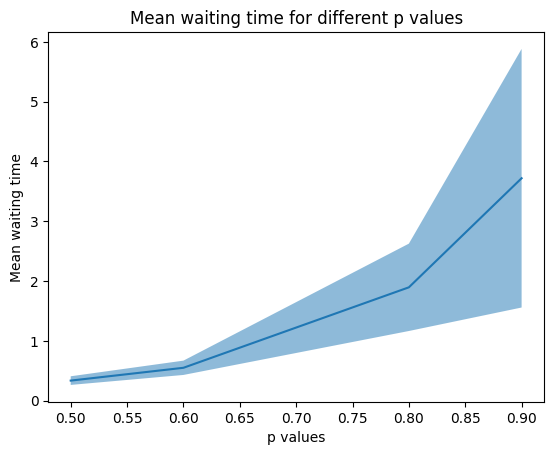

[0.21525663 0.21767246 0.38540747 0.58123573]
